# Visualización

TODO:

* Histograma stacked por número de vícitimas y número de asesinos.
* Resaltar con anotaciones casos importantes
* Mapa con los países. 
* Bubble Clouds con tipo de motivación y país. 
* Diferencia entre las víctimas probadas y probables. lolly pop chart


In [258]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
colores = ["#000000", "#3D0000","#950101"," #FF0000", "#6E1722"]
plt.rcParams["figure.dpi"] = 300
plt.rcParams["font.family"] = "Fira Sans Extra Condensed"

In [102]:
last_kills = pd.DataFrame(data={'año_inicio':[2020] ,'proven_victims':[7]})
last_kills

,año_inicio,proven_victims
0,2020,7


In [112]:
serial_killers = pd.read_excel("output/serial_killers.xlsx")
serial_killers = serial_killers.append(last_kills, ignore_index=True)
serial_killers = serial_killers[serial_killers.año_inicio >= 1900]

serial_killers['año'] = pd.to_datetime(serial_killers.año_inicio.map(str) + '-01-01')
serial_killers.columns

Index(['Name', 'pais_1', 'pais_2', 'pais_3', 'año_inicio', 'año_termino',
       'proven_victims', 'possible_victims', 'Notes', 'tipo_asesino',
       'identificado', 'views', 'año'],
      dtype='object')

In [113]:
ts = serial_killers[['año','proven_victims']].groupby('año').sum()
ts

,proven_victims
año,
1900-01-01,55
1905-01-01,10
1906-01-01,36
1907-01-01,33
1908-01-01,12
...,...
2011-01-01,71
2014-01-01,10
2015-01-01,9


# Gráfico línea de tiempo con cantidad de víctimas

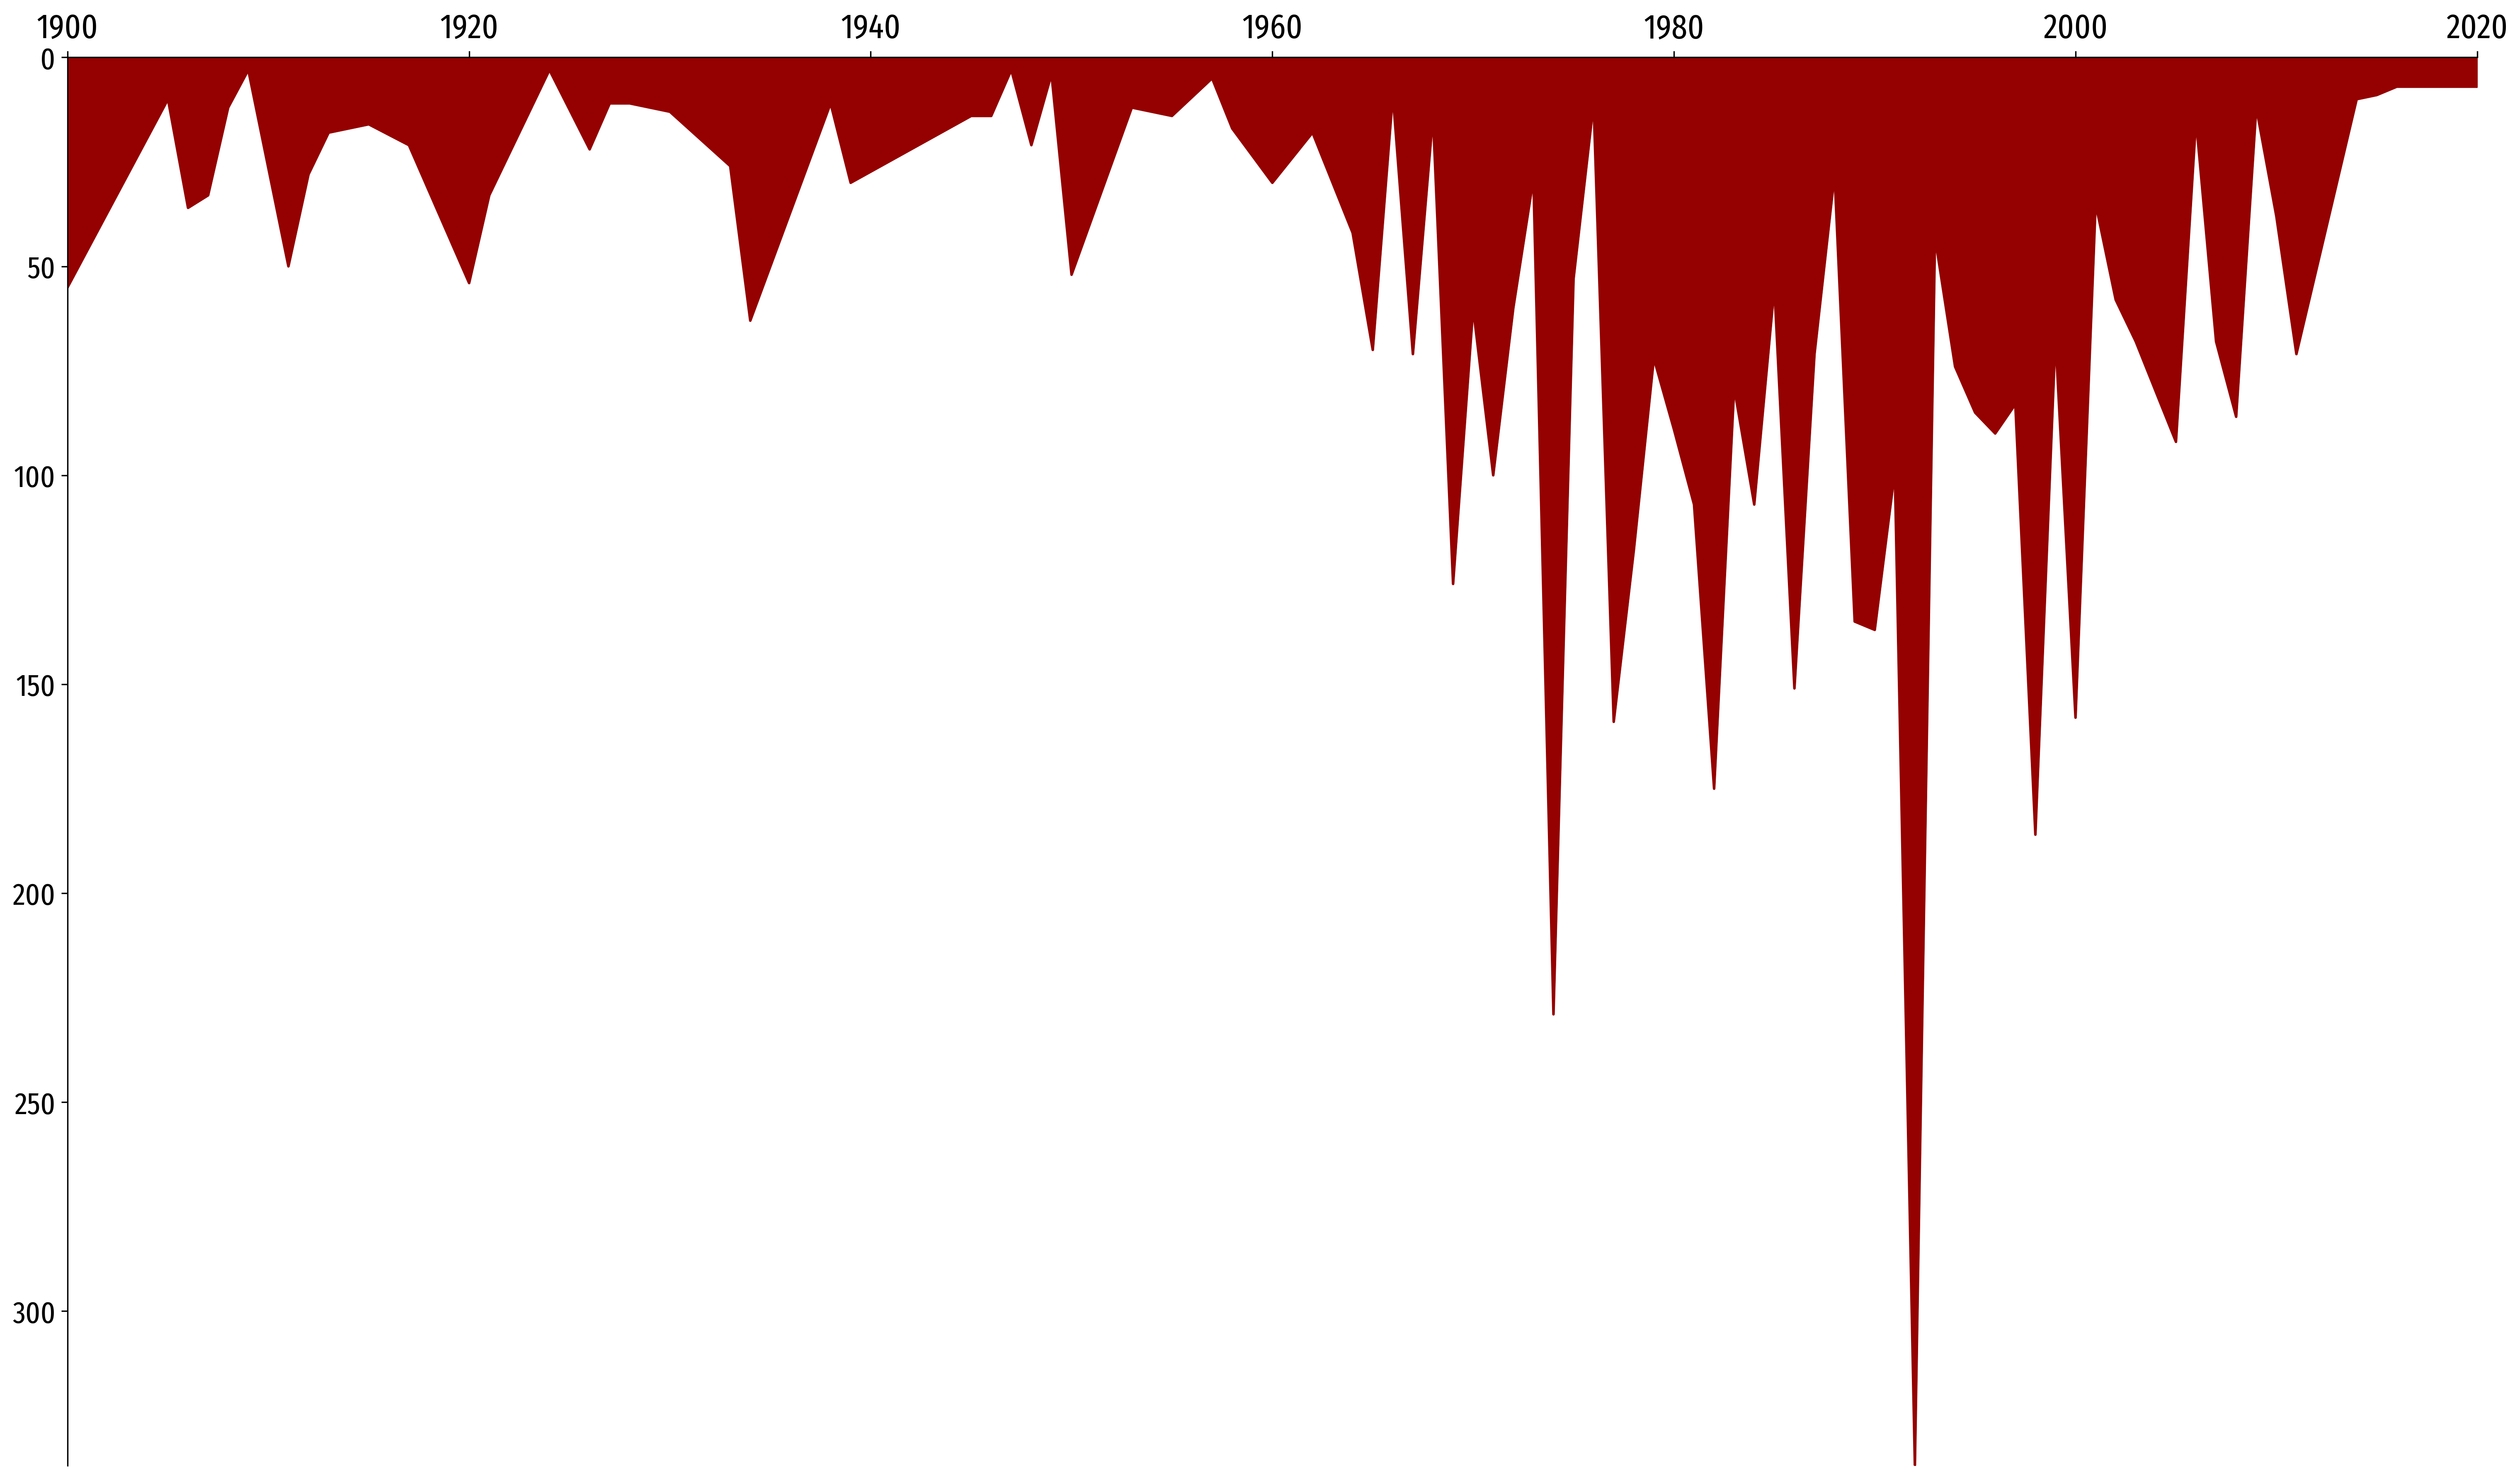

In [118]:
fig = plt.figure(figsize=(25,15), dpi = 300)
ax = fig.add_subplot(1, 1, 1)
ax.xaxis.set_ticks_position('top')
ax.invert_yaxis()
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.xticks(fontsize=20)
plt.yticks(fontsize=18)
ax.margins(0)
plt.xlim(pd.to_datetime('1900-01-01'),pd.to_datetime( '2020-01-01'))
ax.plot(ts.index, ts.proven_victims, linewidth = 1.5, color ='#950000' )
plt.fill_between(ts.index, ts.proven_victims, color = '#950000')#
#plt.savefig('output/vis/hist.svg', transparent=True)

# Gráfico mapa con n° de asesinos en serie

In [131]:
#Mapa en geojson
mapa = gpd.read_file('https://raw.githubusercontent.com/simonepri/geo-maps/master/previews/countries-coastline.geo.json')
country_dict = pd.read_excel("output/country_dict.xlsx")

In [132]:
country_dict = country_dict.merge(mapa, on='A3')
country_dict

,name,A3,geometry
0,Afghanistan,AFG,"POLYGON ((61.27000 35.61000, 61.37000 35.62000..."
1,Åland Islands,ALA,"MULTIPOLYGON (((19.84000 60.42000, 20.27000 60..."
2,Albania,ALB,"POLYGON ((19.37000 41.85000, 19.41000 42.10000..."
3,Algeria,DZA,"POLYGON ((8.64000 36.94000, 8.67000 36.82000, ..."
4,American Samoa,ASM,"MULTIPOLYGON (((-170.76000 -14.37000, -170.840..."
...,...,...,...
230,Wallis and Futuna,WLF,"POLYGON ((-176.17000 -13.28000, -176.18000 -13..."
231,Western Sahara,ESH,"POLYGON ((-13.19000 27.63000, -8.81000 27.6600..."
232,Yemen,YEM,"MULTIPOLYGON (((42.77000 16.40000, 42.95000 16..."
233,Zambia,ZMB,"POLYGON ((24.00000 -10.89000, 24.12000 -10.910..."


Creo vector de países (hay asesinos en serie que actuaron en más de un país)

In [306]:
paises = serial_killers['pais_1']
paises = paises.append(serial_killers['pais_2'], ignore_index=True)
paises = paises.append(serial_killers['pais_3'], ignore_index=True)
paises = pd.DataFrame(data={'country':paises})
paises = paises[~paises['country'].isnull()]
paises.head()

,country
0,Germany
1,Brazil
2,Colombia
3,Swaziland
4,China


In [307]:
n_pais = pd.DataFrame(data = {'count':paises.value_counts('country')})
n_pais.head()

,count
country,
United States,98
Russia,48
South Africa,19
Germany,13
United Kingdom,13


In [308]:
n_pais = country_dict.merge(n_pais, how='left',right_index=True, left_on='name').drop('A3', axis=1).set_index('name')

In [339]:
n_pais = gpd.GeoDataFrame(n_pais)
n_pais = n_pais.replace(np.nan, 0)
n_pais = n_pais[(n_pais.index != 'Antarctica' ) & (n_pais.index !='Greenland')]

In [340]:
ceros = n_pais[n_pais['count'] == 0]
ceros = pd.DataFrame(data=ceros.index)

In [193]:
from aves.visualization.maps import choropleth_map
from aves.visualization.figures import figure_from_geodataframe, GeoFacetGrid

Text(0.0, 1.0, 'Distancia al Trabajo [m]')

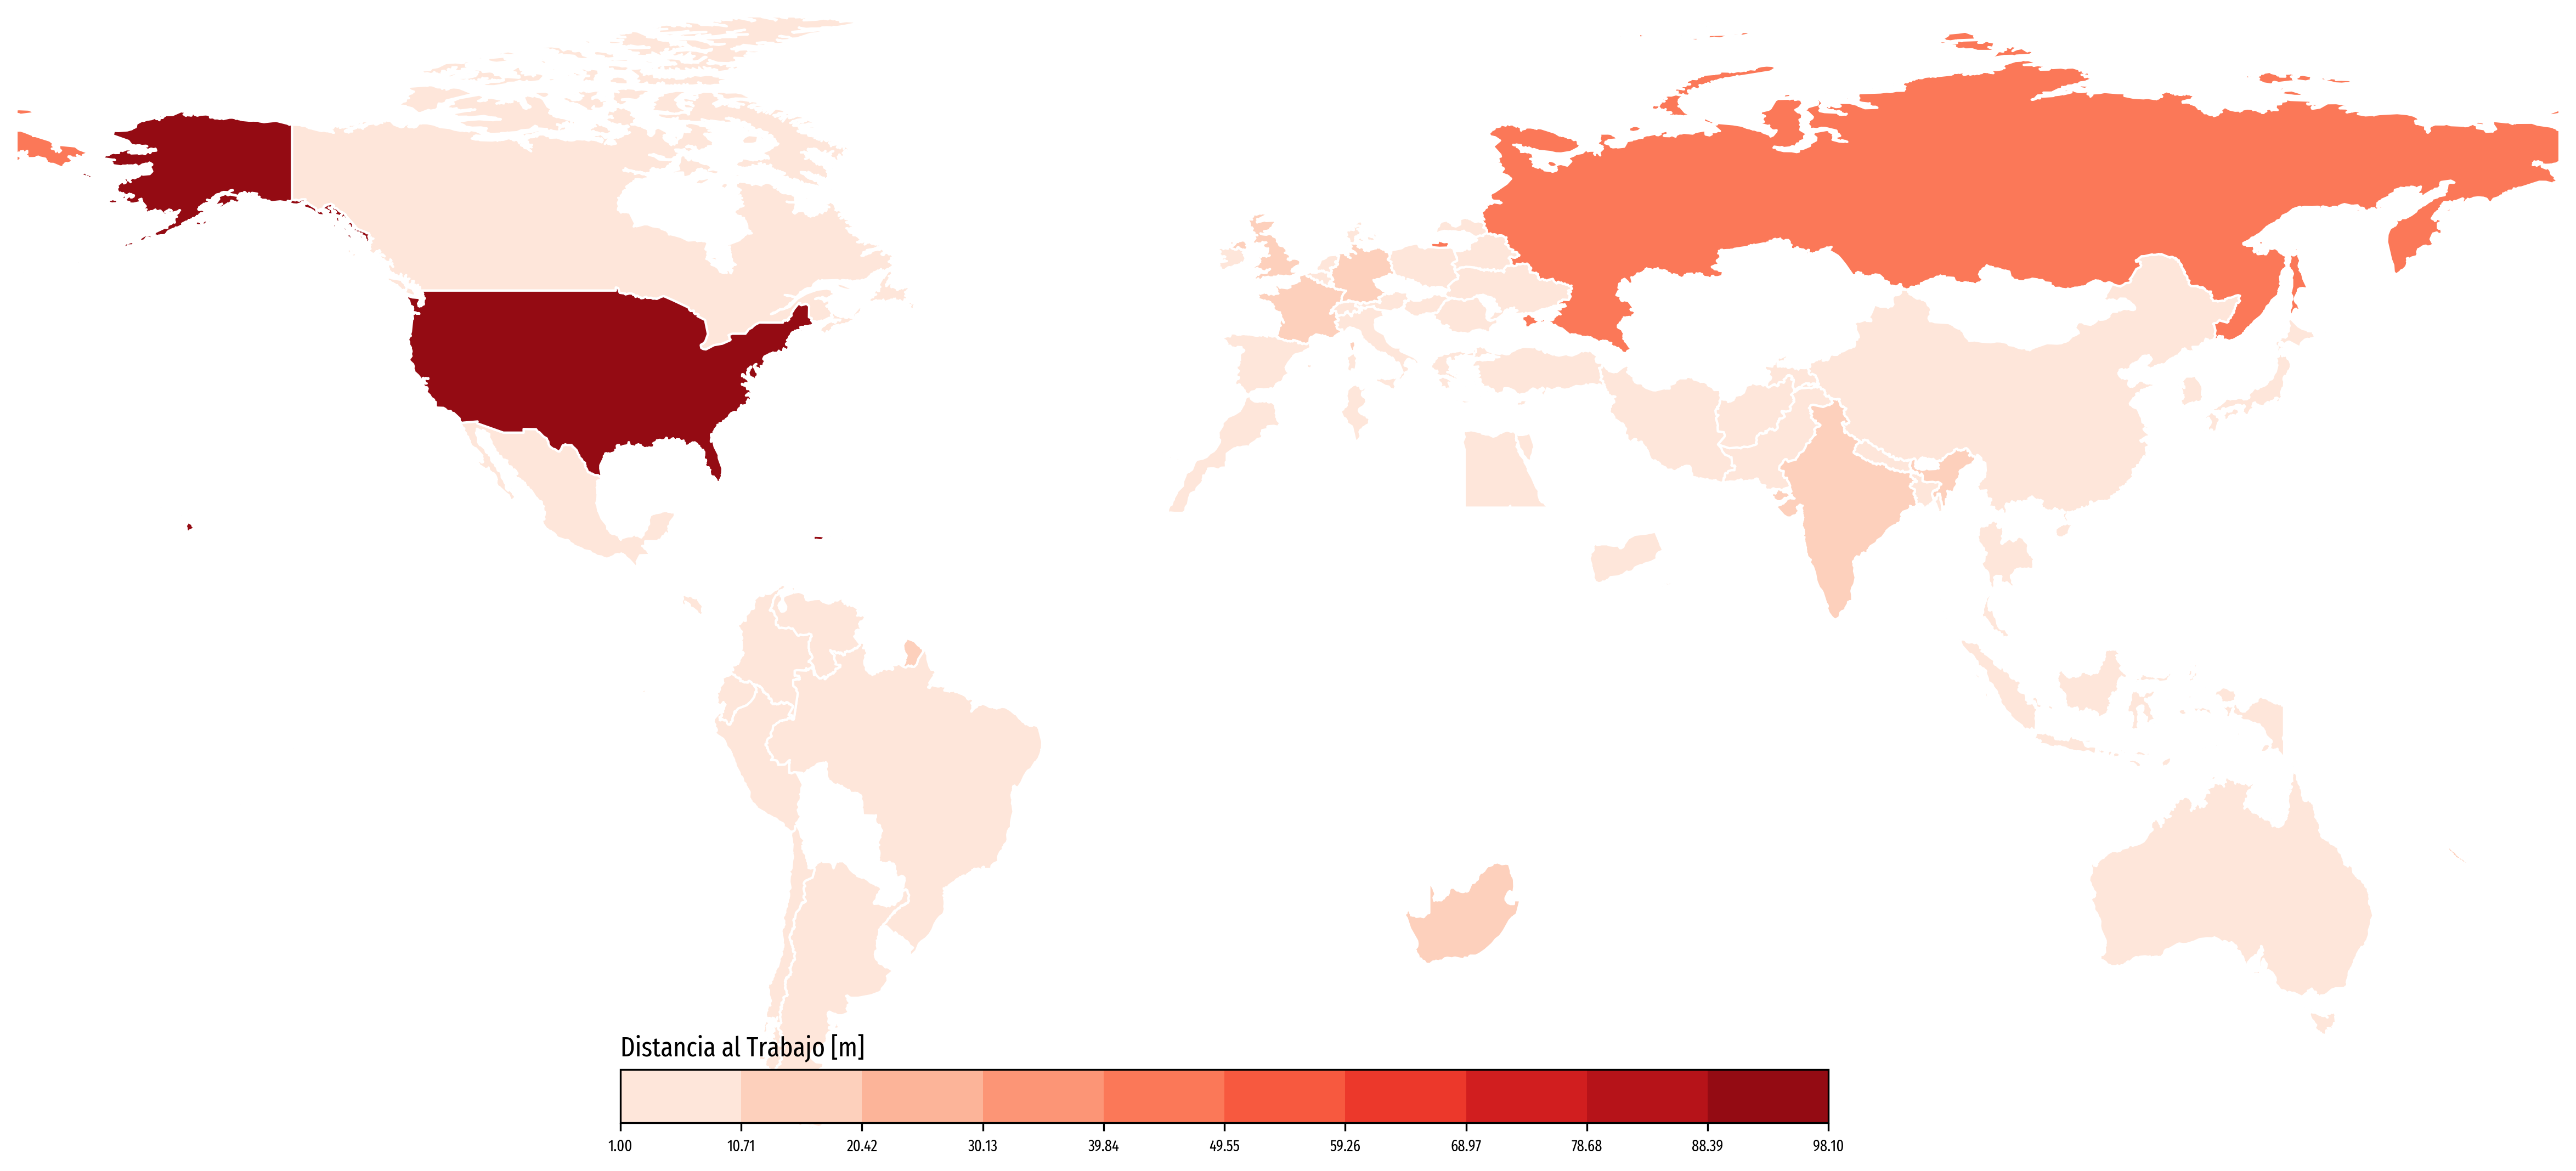

In [192]:
fig, ax = figure_from_geodataframe(n_pais, height=9, remove_axes=True)

ax, cax = choropleth_map(ax, n_pais, 'count')
cax.set_title('Distancia al Trabajo [m]', loc='left')

#fig.tight_layout()

/Users/fabianalexis/opt/anaconda3/envs/aves/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


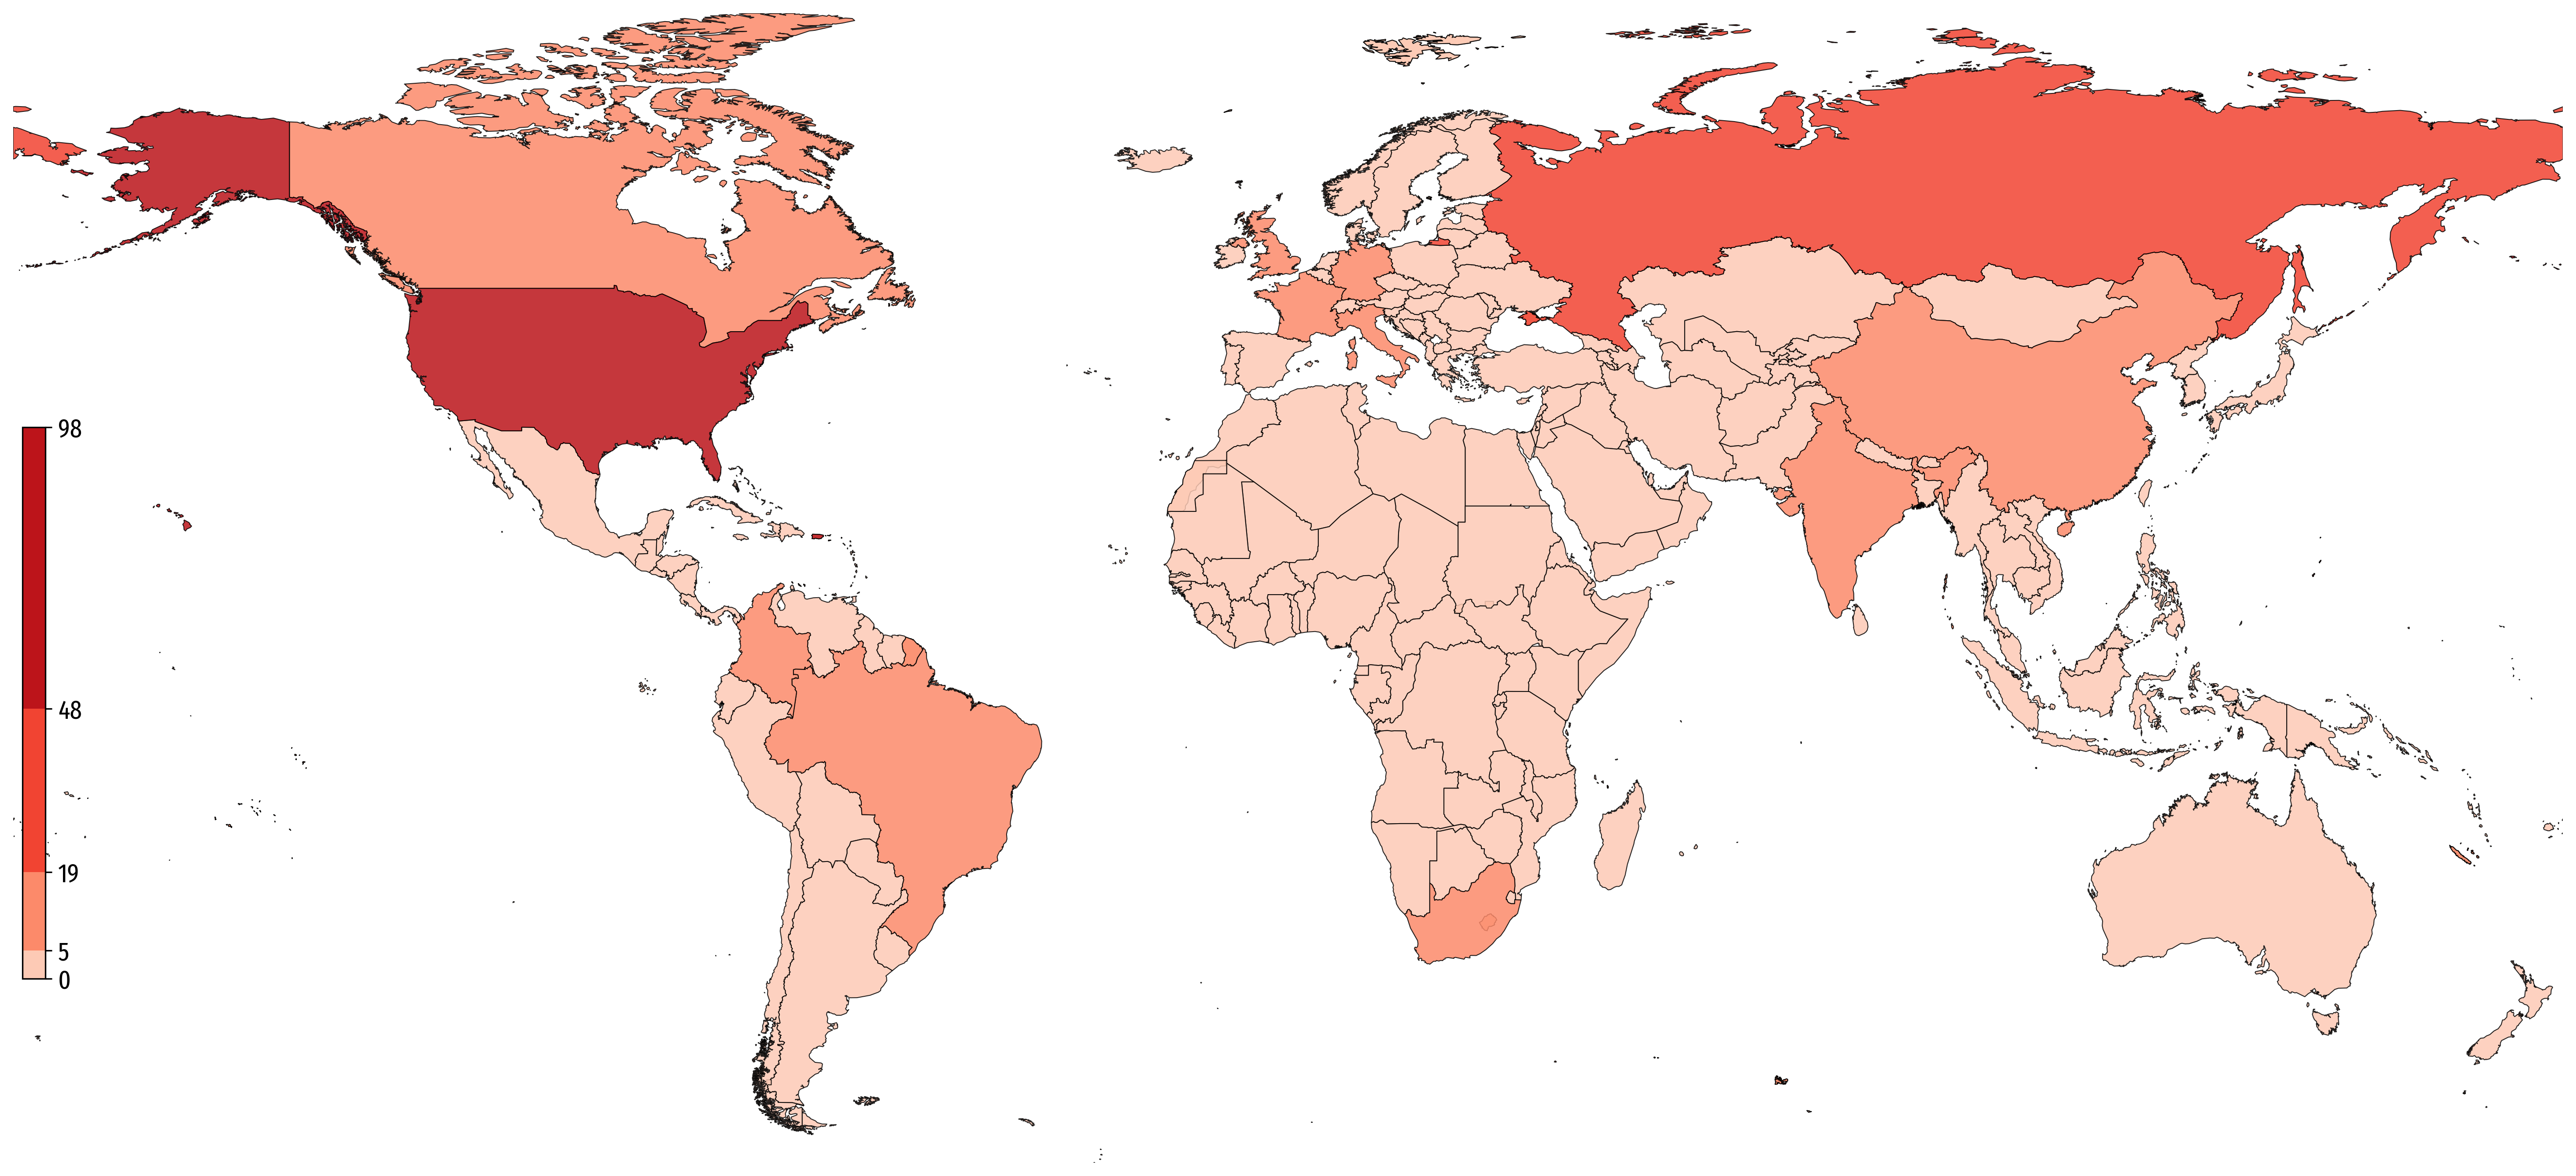

In [342]:
grid = GeoFacetGrid(n_pais, height=9)

#grid.add_basemap() 
grid.add_layer(
    choropleth_map,
    "count",
    k=4,
    linewidth=0.5,
    edgecolor="black",
    binning="fisher_jenks",
    #palette='YlOrRd',
    palette = 'Reds',
    alpha=0.85,
    cbar_args=dict(
        height="60%",
        width="1%",
        orientation="vertical",
        location="center left",
        label_size='x-large',
        bbox_to_anchor=(0, 0.0, 0.9, 0.8),
       # label="N° de asesinos",
    ),
)
#grid.set_title()
grid.tight_layout()
grid.savefig("output/vis/map.svg", transparent=True)